---
title: Visualising preference flows in 2024 QLD state elections
date: 2025-03-10
categories:
    - sankey
    - elections
image: _qld_sankey.png
---

I have recently written a dashboard to explore the preference flows of votes during the 
[2024 QLD state elections](https://en.wikipedia.org/wiki/2024_Queensland_state_election).
The dashboard is available [here](http://apps.sandeepdhakal.xyz/qld-pref-explorer/).

The dashboard has three tabs:
1. Overall preference flows,
2. Preference flows in each electorate,
3. A what-if scenario to test the impact of different levels of preference flows from the Greens to Labor.

In this noitebook, I will discuss how I generated the overall preference flow Sankey diagram and a corresponding table.

# Getting the data

The election data is available from the [QLD Electoral commission](https://resultsdata.elections.qld.gov.au/SGE2024-electorates.json).

The first step is to get data about all the electorates. This is available in the form of a JSON file from the QEC website.

In [1]:
import pprint

import requests

electorates_url = "https://resultsdata.elections.qld.gov.au/SGE2024-electorates.json"
resp = requests.get(electorates_url)

electorates = resp.json()["electorates"]

In [2]:
pprint.pp(electorates[0], depth=2)

{'electorateId': 893,
 'parentElectorateId': None,
 'electorateName': 'Algester',
 'stub': 'algester',
 'contestType': 'State',
 'electorateType': 'State',
 'votingMethod': 'Attendance Ballot',
 'votingSystem': 'Compulsory Preferential Voting',
 'votingSystemMayor': None,
 'votingSystemCouncillor': None,
 'indicativeCount': True,
 'candidatesCount': 6,
 'candidates': [{...}, {...}, {...}, {...}, {...}, {...}],
 'enrolment': 40236}


There's lots of information about each electorate inlcuding the candidates and total enrolment. But we're mostly interested in the electorate's name and the code (_stub_) used by the QEC API.

In [3]:
electorate_names = [x["stub"] for x in electorates]

## Preference count for each electorate

The first preference votes, preference flows and the final result are all available with a single API call.

> https://resultsdata.elections.qld.gov.au/SGE2024-preference-count-district-{electorate_stub}.json

Let's see what it looks like for the _Aspley_ electorate.

In [4]:
from string import Template

prefs_url = Template(
    "https://resultsdata.elections.qld.gov.au/SGE2024-preference-count-district-$electorate.json"
)
electorate = "aspley"
res = requests.get(prefs_url.substitute(electorate=electorate))
result = res.json()

pprint.pp(result, depth=2)

{'contest': 'state',
 'electorateName': 'Aspley',
 'countround': 4,
 'lastUpdated': '2024-11-13T14:43:05.097649+10:00',
 'totalFormalVotes': 35747,
 'totalVotes': 35747,
 'candidates': [{...}, {...}],
 'totalPrimary': 35747,
 'preferenceDistributionDetails': {'distributions': [...], 'primary': [...]},
 'totalExhausted': 0,
 'totalExhaustedPercentage': '0.00%',
 'votesRemainingInCount': 35747,
 'votesRemainingInCountPercentage': '100.00%'}


This json file has a lot of information. So let's break this down into different chunks.

### Primary votes
The primary votes obtained by each candidate are provided as `preferenceDistributionDetails > primary`. This is a list containing information for each candidate.

In [5]:
result["preferenceDistributionDetails"]["primary"]

[{'ballotName': 'HALL, Allan',
  'ballotOrderNumber': 1,
  'party': "Pauline Hanson's One Nation Queensland Division",
  'partyCode': 'One Nation',
  'primary': 1539},
 {'ballotName': 'CAPELL, Wayne',
  'ballotOrderNumber': 2,
  'party': 'Family First Queensland',
  'partyCode': 'Family First',
  'primary': 707},
 {'ballotName': 'MELLISH, Bart',
  'ballotOrderNumber': 3,
  'party': 'Australian Labor Party (State of Queensland)',
  'partyCode': 'Australian Labor Party',
  'primary': 13988},
 {'ballotName': 'COOPER, Amanda',
  'ballotOrderNumber': 4,
  'party': 'Liberal National Party of Queensland',
  'partyCode': 'LNP',
  'primary': 15696},
 {'ballotName': 'HAWKINS, Fiona',
  'ballotOrderNumber': 5,
  'party': 'Queensland Greens',
  'partyCode': 'The Greens',
  'primary': 3817}]

### Final tally
The final tally is available as the `candidates` key in the JSON result.

In [6]:
result["candidates"]

[{'ballotName': 'MELLISH, Bart',
  'ballotOrderNumber': 3,
  'party': 'Australian Labor Party (State of Queensland)',
  'partyCode': 'Australian Labor Party',
  'count': 17889,
  'percentage': '50.04%'},
 {'ballotName': 'COOPER, Amanda',
  'ballotOrderNumber': 4,
  'party': 'Liberal National Party of Queensland',
  'partyCode': 'LNP',
  'count': 17858,
  'percentage': '49.96%'}]

### Preference distributions
This contains information about each preference distribution: the excluded candidate, preferences distributed to each remaining candidate, and the new tally of the remaining candidates.

In [7]:
pprint.pp(result["preferenceDistributionDetails"]["distributions"][0], depth=3)

{'exclusion': 1,
 'excludedCandidate': 'CAPELL, Wayne',
 'excludedCandidateBallotOrder': 2,
 'excludedCandidateParty': 'Family First Queensland',
 'excludedCandidatePartyCode': 'Family First',
 'excludedCandidateVotes': 707,
 'exhausted': 0,
 'exhaustedPercentage': '0.00%',
 'totalExhausted': 0,
 'votesDistributed': 707,
 'votesRemainingInCount': 35747,
 'preferences': [{'ballotName': 'HALL, Allan',
                  'ballotOrderNumber': 1,
                  'party': "Pauline Hanson's One Nation Queensland Division",
                  'partyCode': 'One Nation',
                  'preferences': 302,
                  'preferencesPercentage': '42.72%',
                  'runningTotal': 1841},
                 {'ballotName': 'MELLISH, Bart',
                  'ballotOrderNumber': 3,
                  'party': 'Australian Labor Party (State of Queensland)',
                  'partyCode': 'Australian Labor Party',
                  'preferences': 113,
                  'preferencesPercentag

## Downloading all data

Next, we want to dowload all the data and save that somewhere to avoid repeating the API calls.

Before doing that, lets also assign colours to the parties. These are based on the colours commonly associated with these parties.
https://peo.gov.au/understand-our-parliament/your-questions-on-notice/questions/what-are-the-colours-of-the-australian-political-parties

I've assigned unique colours to other parties whose colours I'm not aware of. And we also need colours for independents.

In [8]:
colours = {
    "ALP": "#FF0000",
    "Family First": "#1CE6EF",
    "KAP": "#8B0000",
    "LCQP": "#788D66",
    "LNP": "#0000FF",
    "One Nation": "#FFA500",
    "The Greens": "#00FF00",
    "Animal Justice Party": "#885578",
    "Libertarians": "#FF34FF",
}

# For independent candidates
other_colours = [
    "#000000",
    "#FFFF00",
    "#FAD09F",
    "#FF8A9A",
    "#D157A0",
    "#FF4A46",
]

Based on the structure of the results we saw above and also the requirements for this project, we will create three dataframes focusing on the _first preferences_, _final result_, and the _distributions_.

We'll use `pandas`, particularly the `json_normalize` and the `DataFrame.from_records` - based on the JSON structure provided by the API.

In [9]:
import pandas as pd

Let's specify what keys we are interested in.

In [10]:
exclusion_cols = [
    "exclusion",
    "excludedCandidate",
    "excludedCandidatePartyCode",
    "excludedCandidateBallotOrder",
    "votesDistributed",
]
pref_cols = [
    "ballotName",
    "preferences",
    "preferencePercentage",
    "runningTotal",
    "partyCode",
    "ballotOrderNumber",
]

We'll define a couple of methods to parse the data from the JSON.

The first method we'll define is to parse the votes received by candidates in either the _primary_ count or the final count. We have already seen the strucutre of this data above. One key difference between the _primary_ and _final_ counts is the keys used to denote the votes: _primary_ and _count_ respectively. We'll get around this by rename the _primary_ column to _count_ (if it exists) in the dataframe.

In [11]:
def parse_candidate_votes(data):
    """Parse the votes received by each candidate in the `data`."""
    counts = pd.DataFrame.from_records(data, exclude=["party"]).rename(
        columns={
            "ballotName": "candidate",
            "ballotOrderNumber": "ballotOrder",
            "partyCode": "party",
            "primary": "count",  # rename 'primary' to 'count' if it exists
        }
    )
    # Now we have a 'count' column irrespective of the data

    # assign colours to the candidates based on their party
    counts["colour"] = counts["party"].map(colours)

    # independents without a party colour
    no_colour = counts["colour"].isna()
    counts.loc[no_colour, ["colour"]] = other_colours[: no_colour.sum()]
    return counts

The next method is to parse the preference distributions in each distribution round. This will take a list of distributions and return a dataframe.

In [12]:
def parse_distribution(data):
    distribution = pd.json_normalize(data, "preferences", exclusion_cols)

    # remove redundant columns
    distribution = distribution.loc[
        :, distribution.columns.isin(exclusion_cols + pref_cols)
    ]

    # rename columns
    distribution = distribution.rename(
        columns={
            "ballotName": "toCandidate",
            "ballotOrderNumber": "toBallotOrder",
            "partyCode": "toParty",
            "runningTotal": "toRunningTotal",
            "excludedCandidate": "fromCandidate",
            "excludedCandidatePartyCode": "fromParty",
            "excludedCandidateBallotOrder": "fromBallotOrder",
        }
    )
    return distribution

Now, we're ready to download the data.

In [13]:
first_prefs, distributions, final_tallies = [], [], []
for electorate in [x["stub"] for x in electorates]:
    res = requests.get(prefs_url.substitute(electorate=electorate))
    result = res.json()

    # first preferences
    first_pref = parse_candidate_votes(
        result["preferenceDistributionDetails"]["primary"]
    )
    first_pref["electorate"] = electorate
    first_pref = first_pref.sort_values("count")
    first_prefs.append(first_pref)

    # final tally
    final = parse_candidate_votes(result["candidates"])
    final["electorate"] = electorate
    final = final.sort_values("count")
    final_tallies.append(final)

    # preference distribution
    data = result["preferenceDistributionDetails"]["distributions"]
    distribution = parse_distribution(data)
    distribution["electorate"] = electorate  # add electorate information
    distributions.append(distribution)

## Tidy 
Let's tidy the data.

- Concatenate data for each electorate into a single dataframe
- Set appropriate data types
- Rename 'Australian Labor Party' to 'ALP'
- Set 'IND' as the party value for independents - it is currently an empty string

In [14]:
# we'll concatenate all electorate data into one dataframe for each data type
distribution = pd.concat(distributions).set_index("electorate")
first_pref = pd.concat(first_prefs).set_index("electorate")
final_tally = pd.concat(final_tallies)

# set appropriate data types for each dataframe
distribution = distribution.astype(
    {
        "toBallotOrder": "uint8",
        "preferences": "uint16",
        "toRunningTotal": "uint16",
        "exclusion": "uint8",
        "fromBallotOrder": "uint8",
        "votesDistributed": "uint16",
        "toParty": "category",
        "fromParty": "category",
    }
)

first_pref = first_pref.astype(
    {
        "ballotOrder": "uint8",
        "count": "uint16",
        "party": "category",
        "colour": "category",
    }
)

final_tally = final_tally.astype(
    {
        "ballotOrder": "uint8",
        "party": "category",
        "count": "uint16",
        "colour": "category",
    }
)

# rename Australian Labor Party to ALP
distribution["toParty"] = distribution["toParty"].cat.rename_categories(
    {"Australian Labor Party": "ALP"}
)
distribution["fromParty"] = distribution["fromParty"].cat.rename_categories(
    {"Australian Labor Party": "ALP"}
)
final_tally["party"] = final_tally["party"].cat.rename_categories(
    {"Australian Labor Party": "ALP"}
)
first_pref["party"] = first_pref["party"].cat.rename_categories(
    {"Australian Labor Party": "ALP"}
)

# Change independent candidates' party from <empty-string> to "Ind."
IND = "Ind."

distribution["toParty"] = distribution["toParty"].cat.rename_categories({"": IND})
distribution["fromParty"] = distribution["fromParty"].cat.rename_categories({"": IND})

final_tally["party"] = final_tally["party"].cat.rename_categories({"": IND})
first_pref["party"] = first_pref["party"].cat.rename_categories({"": IND})

# Tabular Visualisation

First, let's generate a pretty table using pandas. *Note*: we need `matplotlib` to use the background_gradient syle of pandas.

Some quick observations:
- The most votes were transferred from the Greens and One Nation, and the LNP had one of the fewest transfers because they were almost always either 1st or 2nd.

Let's look at the overall preference flows for the entire state.
But first, I'll ignore the independents (those with an empty _party_ name).

In [15]:
distribution_party = distribution[
    (distribution["fromParty"] != IND) & (distribution["toParty"] != IND)
]

distribution_party.pivot_table(
    index=["fromParty"],
    columns=["toParty"],
    values="preferences",
    aggfunc="sum",
    margins=True,
    margins_name="Total",
    observed=True,
    fill_value=0,
).style.background_gradient(axis=1, cmap="BuPu")

toParty,Animal Justice Party,ALP,Family First,KAP,LCQP,LNP,Libertarians,One Nation,The Greens,Total
fromParty,,,,,,,,,,
Animal Justice Party,0,1654,592,0,999,1328,35,1383,3954,9945
ALP,0,0,0,15872,0,16167,0,3108,6912,42059
Family First,393,9923,0,669,3197,14244,53,21496,9489,59464
KAP,0,12871,0,0,0,25268,0,1475,229,39843
LCQP,0,19909,607,1317,0,12438,114,15557,10781,60723
LNP,0,8239,0,0,0,0,0,0,3030,11269
Libertarians,0,954,92,0,64,2176,0,606,1044,4936
One Nation,0,71986,0,13086,664,190359,593,0,23888,300576
The Greens,0,242729,680,2505,5846,67648,0,14919,0,334327


# Sankey diagram of preference flows

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
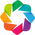

In [16]:
import holoviews as hv
from holoviews import dim

hv.extension("bokeh")

The first step to generate a saneky diagram of preference flows is to get total flows from each party to every other party.
For this, we'll group the `distribution` dataframe by `fromParty` and `toParty` columns and sum all the preference flows for every such pair.

In [17]:
total_dist_flows = distribution_party.groupby(["fromParty", "toParty"], observed=True)[
    ["preferences"]
].sum()
total_dist_flows.head(10)

preferences
fromParty            toParty                  
Animal Justice Party ALP                  1654
                     Family First          592
                     LCQP                  999
                     LNP                  1328
                     Libertarians           35
                     One Nation           1383
                     The Greens           3954
ALP                  KAP                 15872
                     LNP                 16167
                     One Nation           3108

We can now calculate what percent of pref flows from a party to every other party out of the total preference flows from that party.
We'll do this for both incoming and outgoing flows. For example, what percentage of One Nation's total preference distributions went to LNP, and what percent of LNP's incoming preferences came from One Nation.

In [18]:
total_dist_flows["from_pct"] = (
    total_dist_flows["preferences"]  # each party-to-party distribution
    # divided by the total distributions from the 'fromParty'
    / total_dist_flows.groupby(["fromParty"], observed=True)["preferences"].transform(
        "sum"
    )
) * 100  # as a percentage

total_dist_flows["to_pct"] = (
    total_dist_flows["preferences"]  # each party-to-party distribution
    # divided by the total distributions to the 'toParty'
    / total_dist_flows.groupby(["toParty"], observed=True)["preferences"].transform(
        "sum"
    )
) * 100  # as a percentage

We'll use the [Sankey diagrams](https://holoviews.org/reference/elements/bokeh/Sankey.html) from Holoviews. `holoviws.Sankey` requires as input a list of tuples of the form (_from_, _to_, _value_). Here's a slightly modified example from the official documentation:
```python
    nodes = ["PhD", "Career Outside Science",  "Early Career Researcher", "Research Staff",
             "Permanent Research Staff",  "Professor",  "Non-Academic Research"]
    nodes = hv.Dataset(enumerate(nodes), 'index', 'label')
    edges = [
        (0, 1, 53), (0, 2, 47), (2, 6, 17), (2, 3, 30), (3, 1, 22.5), (3, 4, 3.5), (3, 6, 4.), (4, 5, 0.45)   
    ]
    
    value_dim = hv.Dimension('Percentage', unit='%')
    careers = hv.Sankey((edges, nodes), ['From', 'To'], vdims=value_dim)
```

In our case, we first need to assign unique codes to the 'from' and 'to' parties. We want to display each party in the 'from' and 'to' sides so that we can see both outgoing and incoming preference flows for each party. But Holoviews doesn't support acyclic connections.

As a workaround, we'll asign two unique codes for each party, for the 'to' and 'from' sections. Let's start with the outgoing (`fromParty`) flows. For this, we'll use the `codes` attribute of `pandas.Categorical`. The `fromParty` and `toParty` are already categoricals in our dataframe.

In [19]:
# codes for 'from' parties
total_dist_flows["from"] = total_dist_flows.index.get_level_values("fromParty").codes

# unique codes for 'to' parties, starting after the max 'from' code
step = total_dist_flows["from"].max()
total_dist_flows["to"] = total_dist_flows.index.get_level_values("toParty").codes + step

Now, we'll generate the nodes dataset as in the above example.

In [20]:
total_dist_flows = total_dist_flows.reset_index()

from_codes = sorted(
    dict(zip(total_dist_flows["from"], total_dist_flows["fromParty"])).items()
)
to_codes = sorted(
    dict(zip(total_dist_flows["to"], total_dist_flows["toParty"])).items()
)

# merge the from/to_codes to get the dataset
nodes = hv.Dataset(from_codes + to_codes, "index", "party")

Now lets draw the first version of our sankey diagram. Note here that _kdims_ refers to the key variables used by holoviews to index our data. And _vdims_ are the variables that are shown in the result visualisation.

In [21]:
hv.Sankey(
    (total_dist_flows, nodes),
    kdims=["from", "to"],
    vdims=["preferences", "from_pct", "to_pct", "fromParty", "toParty"],
).opts(width=600, toolbar="above")

:Sankey   [from,to]   (preferences,from_pct,to_pct,fromParty,toParty)

There are many ways in which we can improve the above plot.
1. The same parties in the from/to sides don't have the same colours. We need to fix this.
2. We want to show party names instead of codes in the labels.
3. We want to make the hover tooltips better formatted.

We'll do this below.

Let's start with the colormap. We have already defined colours for each party in the beginning. Let's used those colours and create our own colourmap.

In [22]:
cmap = {str(i[0]): colours[i[1]] for i in from_codes + to_codes}

When using the _bokeh_ backend, Holoviews provides [HoverTool](https://holoviews.org/user_guide/Plotting_with_Bokeh.html#hover-tools) to fine tune the tooltips. Let's make use of that.

In [23]:
from bokeh.models import HoverTool

# we'll include from/from_pct and to/to_pct in the same line.
hover = HoverTool(
    tooltips=[
        ("From", "@fromParty (@from_pct %)"),
        ("To", "@toParty (@to_pct %)"),
        ("Transferred", "@preferences{0,0}"),
    ],
)

Putting everything together, we have a much more visually appealing and informative Sankey diagram.

In [24]:
hv.Sankey(
    (total_dist_flows, nodes),
    kdims=["from", "to"],
    vdims=["preferences", "from_pct", "to_pct", "fromParty", "toParty"],
).opts(
    labels="party",
    label_position="outer",
    edge_color=dim("to").str(),
    node_color=dim("index").str(),
    cmap=cmap,
    tools=[hover],
    toolbar="above",
    width=600,
)

:Sankey   [from,to]   (preferences,from_pct,to_pct,fromParty,toParty)

That's the Saneky diagram from the dashboard. The source code for this and the rest of the dashboard is available in github [here](https://github.com/sandeepdhakal/qld-election-pref-explorer).